## Mutation analysis

This is a Jupyter notebook.

To run all cells in the notebook use `Cell --> Run All`.

To run cells one at a time click into the first code cell and key `Shift-Enter` in each cell in sequence.

More information on Jupyter notebooks can be found
[here](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Running%20Code.html).

In [1]:
## Set the plot window sizes within the notebook (in inches)
options(repr.plot.width=8, repr.plot.height=4)

## Load the libraries
library(ggplot2)
library(reshape2)

In [2]:
## Minimum number of mutations per gene to be included in analysis
opt.num = 3 

## File arguments
#fn.hist <- './user_data/UserDogData_Phenotype.csv' # User-provided
#fn.muts <- './user_data/mutations_genesOnly.csv' # Created by the mutations pipeline (see shell scripts)
fn.peps <- './data/CMT_peps.csv'  # PEP lists created in the expression pipeline. This is also Supp Table 1 in the manuscript  
fn.pam50 <- NULL #set to NULL if you don't want to run, filename otherwise

## Filenames that don't change between users
data.dir <- './data/' # Working directory - we should be providing this with the requisite files # TODO: This will need to match the layout we give the whole pipeline. Have it be wherever we store the data
fn.cosmic       <- paste0(data.dir,'genes_COSMIC.csv') # COSMIC genes list, should download most recent version instead of using included one?
fn.pam50.genes  <- paste0(data.dir,'PAM50_genes.csv') # This list will never change, no need to have as input

# max ratio cutoff for genes of interest used in figure 4
max.ratios.cutoff <- 0.15

# Optional: Compare mutation rates in PAM50 genes and subtypes (predicted subtypes generated by PAM50 notebook)
fn.pam50 <- './user_data/output/PAM50_dog.csv'
run.pam50 <- !is.null(fn.pam50)

## Please comment or uncomment the following declarations as appropriate for your run of this notebook:

In [3]:
# Synthetic and "canned" data for testing this notebook (uncomment if needed)
fn.hist <- "./synthetic_data/User_SampleData_Phenotype.csv"
fn.muts <- "./synthetic_data//User_SampleData_Mutations.csv"

# use a lower cutoff for synthetic data
#max.ratios.cutoff <- 0.07

In [4]:
# Create an output directory for artifacts (if it doesn't already exist)
output.dir <- './user_data/output'
system(paste('mkdir -p', output.dir))

# output files
mut.rates.file             <- paste(output.dir,'Sample_Mut_Rates.pdf', sep='/')
density.plot.file          <- paste(output.dir,'Sample_Mutation_Counts_Density.pdf', sep='/')
cosmic.mutations.file      <- paste(output.dir,'COSMIC_Genes_Mutations.pdf', sep='/')
mutations.consistency.file <- paste(output.dir,'MutationConsistency.pdf', sep='/')
freq.mutations.file        <- paste(output.dir,'FreqMutatedGenes_ClinicalCorrelations.csv', sep='/')

In [5]:
## Make sure all of the required files exist - quit if any are missing
for( fn in c(fn.hist, fn.muts, fn.peps, fn.cosmic, fn.pam50.genes) ) {
  if(!file.exists(fn)) { print(paste('ERROR: Unable to locate',fn)); quit(save='no',status=1) }
}

In [6]:
## Load the clinical data, extract dog IDs
print('Loading script data')
dat.hist <- read.table(fn.hist, sep=',', header=TRUE, row.names=1)

[1] "Loading script data"


In [7]:
## Alphabetic IDs for each dog instead of numeric
## Generally don't need this- only CMTGA changes up the names halfway through
dat.hist$Patient <- as.character(dat.hist$Patient) # Ensure patient names are character strings for plotting consistency

In [8]:
## XXX cell disabled for now...

## Load the PAM50 subtypes 
##   This file is created by PAM50_refactored.R, should just port straight over (don't need user to specify)
if(run.pam50) {
  pam50    <- read.table(fn.pam50, sep=',', row.names=1)
    
  print('PAM50 subtype counts per patient:')
  print(table(pam50[,1], dat.hist[rownames(pam50),'Patient']))
    
  dat.hist$PAM50 <- pam50[rownames(dat.hist),1]
}

[1] "PAM50 subtype counts per patient:"
        
         Barney Blanco Butterfly Checkers Faithful Feller Glen Him KingTut
  Her2        0      0         0        0        0      0    0   0       0
  LumA        1      0         1        1        1      0    1   0       4
  LumB        0      0         0        0        0      0    0   0       0
  Normal      2      3         2        2        2      3    3   3       2
        
         LaddieBoy LittleBeagle Manchu Millie MissBeazley Nellie PaloAlto
  Her2           0            0      0      0           0      0        0
  LumA           1            1      2      1           1      3        1
  LumB           0            0      0      0           0      0        0
  Normal         2            2      2      2           2      1        2
        
         PeterPan Pushinka Ranger SailorBoy Searcher Vicky WhiteTips Winks Yuki
  Her2          0        0      0         0        0     0         0     0    1
  LumA          0        1  

In [9]:
## Load the list of COSMIC genes
genes.cosmic <- rownames(read.table(fn.cosmic, sep=',', header=TRUE, row.names=1))

In [10]:
## Load the mutations data, make 0/1 calls instead of # calls per gene
dat <- read.table(fn.muts, sep=',', header=TRUE, row.names=1, check.names=FALSE)

## Create matrix of binary mutation calls
dat.bin <- dat
dat.bin[dat.bin>0] <- 1

In [11]:
## Create 2 matrices: Benign and Malignant samples
print('Creating the mutations matrices.')
dat.m <- dat.bin[,rownames(dat.hist)[dat.hist$Hist=='M']]
dat.b <- dat.bin[,rownames(dat.hist)[dat.hist$Hist=='B']]

## Aggregate mutation calls by patient rather than by sample
dat.m <- t(aggregate(t(dat.m), by=list(dat.hist[colnames(dat.m),'Patient']), FUN=sum))
colnames(dat.m) <- dat.m[1,]
dat.m <- dat.m[-1,]

dat.b <- t(aggregate(t(dat.b), by=list(dat.hist[colnames(dat.b),'Patient']), FUN=sum))
colnames(dat.b) <- dat.b[1,]
dat.b <- dat.b[-1,]

## Convert from character to numeric
class(dat.b) <- 'numeric'
class(dat.m) <- 'numeric'

# For now we don't care about # samples mutated in each gene per patient, just that at least 1 sample is mutated
# So set >1 values to 1
dat.m[dat.m>0] <- 1
dat.b[dat.b>0] <- 1

[1] "Creating the mutations matrices."


In [12]:
#########################################
## Color Palette for manuscript
#####################################
print('Setting color palettes.')

cols <- c('#9DC7D8','#7FA1BE','#EBDA8C','#01B3CA','#4F6E35','#965354','#7DD1B9','#808040','#C6CBCE','#1D4E88','#C78C6C','#F69256','#D2B29E','#8B868C','#E38691','#B490B2') # All colors in palette
cols.hist <- c('#7DD1B9','#EBDA8C','#965354') # order = healthy, benign, malignant
cols.peps <- c('#7FA1BE','#F69256','#E38691') # order = tumor, adenoma, carcinoma

[1] "Setting color palettes."


[1] "Generating mutation histogram"


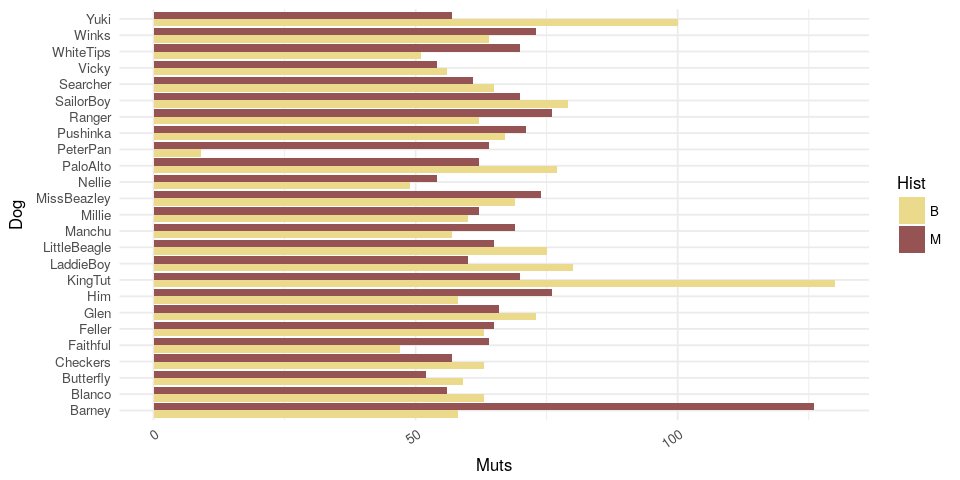

In [13]:
## Create histogram of mutations per sample per histology.
print('Generating mutation histogram')

## Create data frame for patient summaries, converting to alphabet patient IDs instead of numeric
mut.rates <- data.frame(Muts=apply(dat.bin, 2, sum), Hist=dat.hist[colnames(dat.bin),'Hist'], Dog=dat.hist[colnames(dat.bin),'Patient'], Sample=colnames(dat.bin))

## Plot the subfigure
ggplot(mut.rates, aes(Dog, Muts)) + 
    geom_bar(aes(fill = Hist), position = "dodge", stat="identity") + 
    scale_fill_manual(values=cols.hist[2:3]) + 
    theme_minimal() + 
    coord_flip() + 
    theme(axis.text.x=element_text(angle = -325, hjust = 1), text = element_text(size=10))
ggsave(mut.rates.file,width=4,height=10)

[1] "Generating density plot"


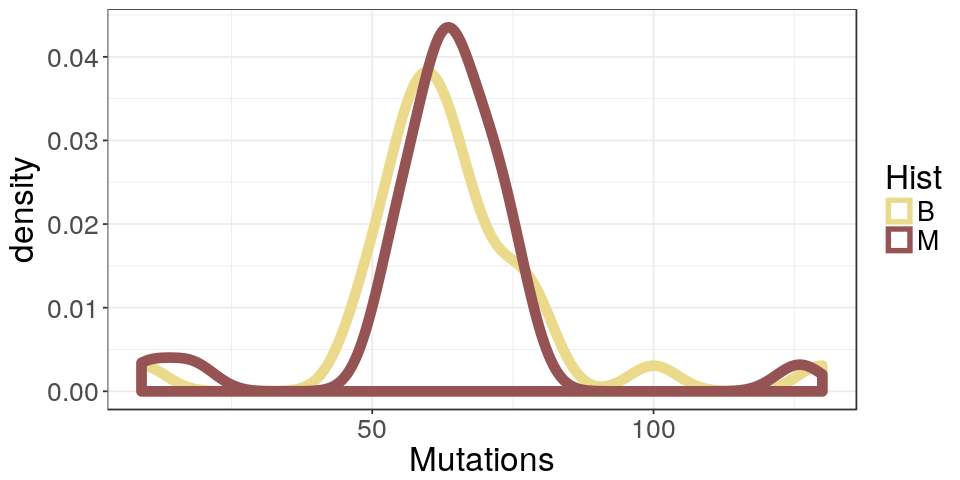

In [14]:
#########################################
## Figure 2a - red&blue density plot
#####################################
print('Generating density plot')

## Count mutations in each benign & malignant sample, create and save density plot
samples.freq <- data.frame(Mutations=apply(dat, 2, sum), Hist=dat.hist[colnames(dat),'Hist'])
ggplot(samples.freq) + geom_density(aes(Mutations,group=Hist,col=Hist),lwd=3) + scale_color_manual(values=cols.hist[2:3]) + theme_bw() + theme(text = element_text(size=20))
ggsave(density.plot.file,width=12, height=4)


In [15]:
## Print the median number of mutated genes per histology
print( paste('Median mutations in benign samples:', median( samples.freq[samples.freq$Hist=='B','Mutations']) ))
print( paste('Median mutations in malignant samples:', median( samples.freq[samples.freq$Hist=='M','Mutations']) ))

[1] "Median mutations in benign samples: 62.5"
[1] "Median mutations in malignant samples: 63.5"


In [16]:
#########################################
## Figure 2b - navy&white dot plot
#####################################
print('Generating pooled mutations plot')

## Calculate most frequently mutated (by % of samples of each type) to get balanced frequently mutated genes
##    Otherwise will give mostly benign mutations, since we have 2x benign samples
ids.benign    <- rownames(dat.hist)[ dat.hist$Hist=='B' ]
ids.tumor     <- rownames(dat.hist)[ dat.hist$Hist=='M' ]
benign.ratios <- apply(dat.bin[,ids.benign], 1, function(x){sum(x==1)/length(x)})
tumor.ratios  <- apply(dat.bin[,ids.tumor], 1, function(x){sum(x==1)/length(x)})
max.ratios    <- apply(cbind(benign.ratios,tumor.ratios), 1, max)

[1] "Generating pooled mutations plot"


In [17]:
## Pick 30 most frequently mutated genes in COSMIC to use in the plots
genes <- names(sort(apply(dat[rownames(dat) %in% genes.cosmic,], 1, function(x){sum(x>0)}),decreasing=TRUE))[1:30] # Use this for the COSMIC plot

# Another option - pick some cutoff of mutated ratios for benign/malignant
#genes            <- names(max.ratios)[max.ratios>0.15] 

print(c('Most frequently mutated COSMIC genes:',genes))

 [1] "Most frequently mutated COSMIC genes:"
 [2] "MLLT6"                                
 [3] "ESR1"                                 
 [4] "RECQL4"                               
 [5] "BMPR1A"                               
 [6] "LRIG3"                                
 [7] "MDM2"                                 
 [8] "ARID1B"                               
 [9] "CCND3"                                
[10] "MYCL"                                 
[11] "MAML2"                                
[12] "LRP1B"                                
[13] "IL6ST"                                
[14] "KMT2D"                                
[15] "NRAS"                                 
[16] "ETV6"                                 
[17] "TET1"                                 
[18] "BRIP1"                                
[19] "RMI2"                                 
[20] "BCL10"                                
[21] "HLF"                                  
[22] "MALT1"                                
[23] "STAT

In [18]:
## Melt the malignant sample matrix
dat.m.melted       <- melt( as.matrix(dat.m[rownames(dat.m) %in% genes,]) )
dat.m.melted$value <- as.numeric(as.character(dat.m.melted$value))
dat.m.melted$value[dat.m.melted$value>0] <- 1
dat.m.melted$value <- as.factor(dat.m.melted$value) # For color scales

## Melt the benign sample matrix
dat.b.melted       <- melt( as.matrix(dat.b[rownames(dat.b) %in% genes,]) )
dat.b.melted$value <- as.numeric(as.character(dat.b.melted$value))
dat.b.melted$value[dat.b.melted$value>0] <- 1
dat.b.melted$value <- as.factor(dat.b.melted$value) # For color scales

## Combine the 2 melted matrices
dat.melted           <- cbind(dat.m.melted, dat.b.melted$value)
colnames(dat.melted) <- c('Gene','Dog','Tumor','Benign')
dat.melted$Dog       <-  as.character(dat.melted$Dog) # So the plot sorts them alphabetically

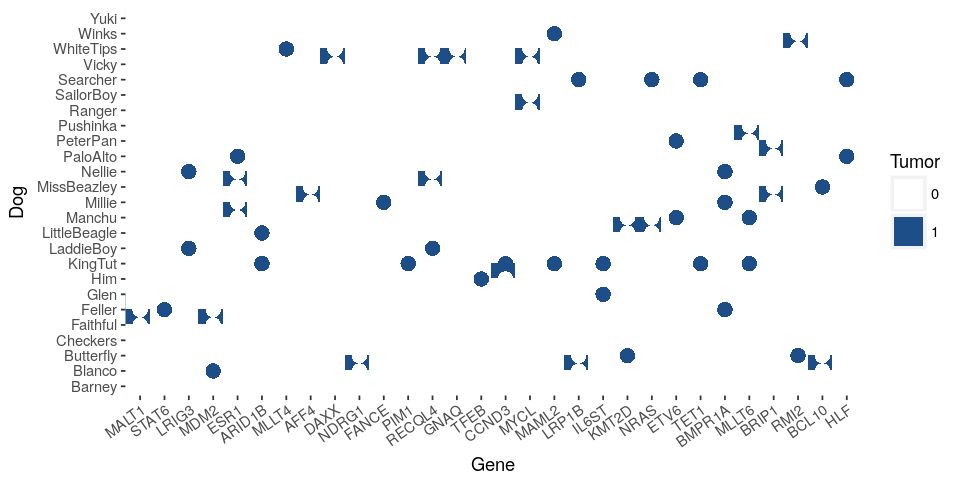

In [19]:
## Plot the result
ggplot(dat.melted) + geom_point(aes(Gene, Dog, col=Tumor), size=8, pch=15) +
  geom_point(aes(Gene,Dog,col=Benign), size=4, pch=16) +
  theme(axis.text.x=element_text(angle = -325, hjust = 1)) +
  scale_color_manual(values=c('white',cols[10]))
ggsave(cosmic.mutations.file, width=10, height=5.5)

[1] "Generating per-sample mutations plot"


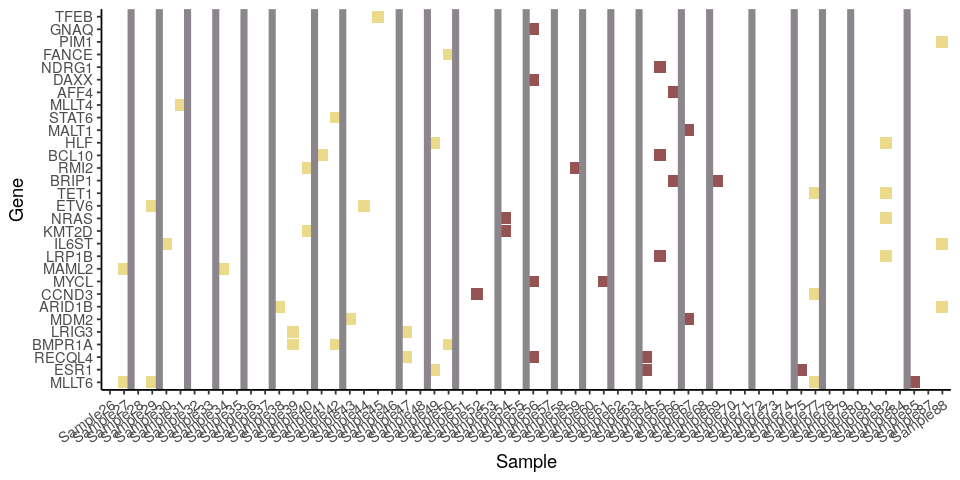

In [20]:
#########################################
## Frequently mutated genes
#####################################

print('Generating per-sample mutations plot')

## Number of samples per patient (used to plot vertical grey dividing lines on the plot)
s.counts         <- table(dat.hist[colnames(dat.bin),'Patient'])

# For our dataset only, reorder the names (because we used numeric patient names :/
#s.counts         <- s.counts[sort(paste0(names(s.counts),'A'),index=TRUE)$ix] 

## Prepare the data for the plot
dat.bin.melted           <- melt(as.matrix(dat.bin[genes,]))
dat.bin.melted           <- dat.bin.melted[,c(2,1,3)]
colnames(dat.bin.melted) <- c('Sample','Gene','Alteration')
dat.bin.melted$Sample    <- as.character(dat.bin.melted$Sample)
dat.bin.melted$Hist      <- dat.hist[ dat.bin.melted$Sample, 'Hist' ]

## Samples by genes plots of mutations, colored by sample histology
ggplot(dat.bin.melted) +
  geom_point(aes(Sample, Gene, color=interaction(factor(Alteration),Hist)),pch=15,size=3) +
  scale_color_manual(values=c('white',cols.hist[2],'white',cols.hist[3])) +
  theme_classic() +
  theme(legend.position='none',axis.text.x=element_text(angle = -325, hjust = 1)) +
  geom_vline(xintercept=cumsum(s.counts[-length(s.counts)])+0.5,col=cols[14],size=2)
ggsave(mutations.consistency.file,width=13,height=7)

In [21]:
## Do the subtypes have different numbers of mutations (total, not just in PAM50 genes)
##   For samples of each subtype, print median num mutations in the samples
num.muts <- apply(dat.bin, 2, sum)

### Are COSMIC genes more frequently mutated than non-COSMIC?
print(res.ttest <- t.test( apply(dat.bin, 1, sum) ~ factor(rownames(dat.bin) %in% genes.cosmic) ))
if( res.ttest$p.value < 0.05) {
  print( paste('COSMIC genes are significantly more frequently mutated than non-COSMIC genes, p-value =', signif(res.ttest$p.value,digits=3)) )
} else {
  print( paste('COSMIC genes are NOT significantly more frequently mutated than non-COSMIC genes, p-value =', signif(res.ttest$p.value,digits=3)) )
}
rm(res.ttest)


	Welch Two Sample t-test

data:  apply(dat.bin, 1, sum) by factor(rownames(dat.bin) %in% genes.cosmic)
t = -0.38644, df = 530.13, p-value = 0.6993
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06315057  0.04238902
sample estimates:
mean in group FALSE  mean in group TRUE 
          0.3094573           0.3198381 

[1] "COSMIC genes are NOT significantly more frequently mutated than non-COSMIC genes, p-value = 0.699"


In [22]:
## Are PAM50 genes more frequently mutated than non-PAM50?

## Print PAM50 subtype sample mutation counts
if(run.pam50) {
  colnames(pam50)[1] <- 'PAM50'
  pam50$Muts <- NA
  pam50[colnames(dat.bin),'Muts'] <- num.muts
  print('PAM50 sample counts:'); flush.console()
  print(sapply( levels(pam50$PAM50), function(x) {median( pam50[pam50$PAM50==x,'Muts'], na.rm=TRUE )} ))
}

#  Only run if enabled
if(run.pam50) {
  genes.pam50 <- rownames(read.table(fn.pam50.genes, sep=',', row.names=1))
  print( res.ttest <- t.test( apply(dat.bin, 1, sum) ~ factor(rownames(dat.bin) %in% genes.pam50) ) ) 
  if( res.ttest$p.value < 0.05) {
    print( paste('PAM50 genes are significantly more frequently mutated than non-PAM50 genes, p-value =', signif(res.ttest$p.value,digits=3)) )
  } else {
    print( paste('PAM50 genes are NOT significantly more frequently mutated than non-PAM50 genes, p-value =', signif(res.ttest$p.value,digits=3)) )
  }
  rm(res.ttest)
}


[1] "PAM50 sample counts:"
  Her2   LumA   LumB Normal 
    NA   63.5   57.0   63.0 

	Welch Two Sample t-test

data:  apply(dat.bin, 1, sum) by factor(rownames(dat.bin) %in% genes.pam50)
t = -0.31992, df = 43.227, p-value = 0.7506
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2274578  0.1651649
sample estimates:
mean in group FALSE  mean in group TRUE 
          0.3097627           0.3409091 

[1] "PAM50 genes are NOT significantly more frequently mutated than non-PAM50 genes, p-value = 0.751"


In [23]:
## Correlate mutations w/clinical factors of interest- this will return a matrix of dat.hist columns by genes, filled with corrected pvals 
print(paste('Calculating correlations between mutations and phenotype data (Patient, Location, Histology, etc) in genes with >',opt.num,'mutations in the cohort.'))
get.pvals <- function(id) {
  phen.cols <- c('Patient','Location','Goldschmidt','Hist','SimHist','DetHist') # Which clinical factors we care about
  phen.cols <- phen.cols[ phen.cols %in% colnames(dat.hist) ] # Make sure these are in the provided phenotype/clinical data
  p.adjust(apply(dat.hist[colnames(dat.bin),phen.cols], 2, function(x) {try(chisq.test(table( factor(x), unlist(dat.bin[id,])))$p.value)}))
}

## Look at most frequently mutated genes, correlate these mutations with phenotypes of interest
genes       <- names(which(apply(dat.bin, 1, sum)>opt.num)) # Only care about frequently mutated genes
print(paste(length(genes),'genes are mutated in at least',opt.num,'samples:'))
print(genes)

if( length(genes) > 0 ) {
  genes.pvals <- sapply(genes, get.pvals)
  write.table(signif(t(genes.pvals),digits=5), file=freq.mutations.file, sep=',', col.names=TRUE, row.names=TRUE, quote=FALSE)
  print('Phenotype/Clinical correlations stored to file.')
} else {
  print('WARNING: Not enough mutated genes for clinical factor correlation analysis, skipping this step.')
}

[1] "Calculating correlations between mutations and phenotype data (Patient, Location, Histology, etc) in genes with > 3 mutations in the cohort."
[1] "6 genes are mutated in at least 3 samples:"
[1] "PLB1"   "IFT57"  "MRPL36" "AGFG1"  "MLLT6"  "NKRF"  


Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(table(factor(x), unlist(dat.bin[id, ]))):


[1] "Phenotype/Clinical correlations stored to file."


In [24]:
## Are PEP list genes more frequently mutated than non-PEP genes?

## Load the PEPs & print PEP genes that are frequently mutated
print('Loading PEPs. PEP list lengths:')
peps <- read.table(fn.peps, sep=',', header=TRUE, stringsAsFactors=FALSE)
peps <- list(Adenoma=peps[peps$Adenoma_Expression_Pattern < 0.05,'HumanSymbol'],
             Carcinoma=peps[peps$Carcinoma_Expression_Pattern < 0.05,'HumanSymbol'], 
             Tumor=peps[peps$Tumor_Expression_Pattern < 0.05,'HumanSymbol'])
print(sapply(peps, length))# Print num genes in each PEP 

print(paste('Checking for frequently mutated PEP genes (>',opt.num,'mutations):'))
pep.mut.counts <- sapply(peps, function(x) { apply(dat.bin[rownames(dat.bin) %in% x,], 1, sum)} )
print(sapply(pep.mut.counts, function(x){ names(x)[which(x>opt.num)] }))
print(sapply(pep.mut.counts, summary))
flush.console()

print('Done with mutation analysis.') 

[1] "Loading PEPs. PEP list lengths:"
  Adenoma Carcinoma     Tumor 
      167       270       901 
[1] "Checking for frequently mutated PEP genes (> 3 mutations):"
$Adenoma
character(0)

$Carcinoma
character(0)

$Tumor
character(0)

          Adenoma Carcinoma     Tumor
Min.    0.0000000  0.000000 0.0000000
1st Qu. 0.0000000  0.000000 0.0000000
Median  0.0000000  0.000000 0.0000000
Mean    0.2837838  0.307377 0.2992701
3rd Qu. 1.0000000  1.000000 1.0000000
Max.    2.0000000  3.000000 3.0000000
[1] "Done with mutation analysis."


Unless the default paths have been changed above the
image files generated by this notebook may be downloaded using the
Jupyter directory browser interface at
[`./user_data/output`](./user_data/output).